### Analyzing Investment Portfolios for Ugandan Health Clinics Endownment
Investment Portfolio Project, ChemE 5660

Chike Murray, Sonny Vo , Erik Kirakosyan

## Setup

In [2]:
include("Include.jl");

    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`


   Resolving package versions...


  No Changes to `~/Desktop/CHEME-5660-Project-Template-F23/Project.toml`
  No Changes to `~/Desktop/CHEME-5660-Project-Template-F23/Manifest.toml`


  Activating project at `~/Desktop/CHEME-5660-Project-Template-F23`


  No Changes to `~/Desktop/CHEME-5660-Project-Template-F23/Project.toml`
  No Changes to `~/Desktop/CHEME-5660-Project-Template-F23/Manifest.toml`


    Updating registry at `~/.julia/registries/General.toml`
    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`


  No Changes to `~/Desktop/CHEME-5660-Project-Template-F23/Project.toml`
  No Changes to `~/Desktop/CHEME-5660-Project-Template-F23/Manifest.toml`


## Prerequisites: Load historical dataset, compute expected returns and get 2023 `SPY` data
We gathered a daily open-high-low-close `dataset` for each firm in the [S&P500](https://en.wikipedia.org/wiki/S%26P_500) since `01-03-2018` until `12-01-2023`, along with data for a few exchange traded funds and volatility products during that time. 

In [107]:
original_dataset = load(joinpath(_PATH_TO_DATA, 
        "SP500-Daily-OHLC-1-3-2018-to-12-01-2023.jld2")) |> x-> x["dataset"];

### Clean the data
Not all of the tickers in our dataset have the maximum number of trading days for various reasons, e.g., acquistion or de-listing events. Let's collect only those tickers with the maximum number of trading days.

* First, let's compute the number of records for a company that we know has a maximim value, e.g., `AAPL` and save that value in the `maximum_number_trading_days` variable:

In [108]:
maximum_number_trading_days = original_dataset["AAPL"] |> nrow

1489

Now, lets iterate through our data and collect only those tickers that have `maximum_number_trading_days` records. Save that data in the `dataset::Dict{String,DataFrame}` variable:

In [109]:
dataset = Dict{String,DataFrame}();
for (ticker,data) ∈ original_dataset
    if (nrow(data) == maximum_number_trading_days)
        dataset[ticker] = data;
    end
end
dataset

Dict{String, DataFrame} with 459 entries:
  "NI"   => 1489×8 DataFrame…
  "EMR"  => 1489×8 DataFrame…
  "CTAS" => 1489×8 DataFrame…
  "HSIC" => 1489×8 DataFrame…
  "KIM"  => 1489×8 DataFrame…
  "PLD"  => 1489×8 DataFrame…
  "IEX"  => 1489×8 DataFrame…
  "BAC"  => 1489×8 DataFrame…
  "CBOE" => 1489×8 DataFrame…
  "EXR"  => 1489×8 DataFrame…
  "NCLH" => 1489×8 DataFrame…
  "CVS"  => 1489×8 DataFrame…
  "DRI"  => 1489×8 DataFrame…
  "DTE"  => 1489×8 DataFrame…
  "ZION" => 1489×8 DataFrame…
  "AVY"  => 1489×8 DataFrame…
  "EW"   => 1489×8 DataFrame…
  "EA"   => 1489×8 DataFrame…
  "NWSA" => 1489×8 DataFrame…
  ⋮      => ⋮

Let's get a list of firms that we have in cleaned up `dataset`, and save it in the `all_tickers` array:

In [110]:
all_tickers = keys(dataset) |> collect |> sort;
K = length(all_tickers);

### Get the 2023 `SPY` data

In [171]:
startdate = Date(2023,01,03);
SPY_dataset = dataset["SPY"];
SPY_df = filter(:timestamp => x-> x >= startdate, SPY_dataset);

### Compute the expected return for all firms in the dataset
The expected return $\mathbb{E}(r_{i})$ and covariance matrix $\Sigma$ will be used in our calculations, so we'll provide values for both of these items for the entire data set (all `N = 459` tickers), and then you can pick out which tickers you are interested in. 

* First, we compute the expected (annualized) log return by passing the `dataset` and the entire list of firms we have in the dataset (held in the $N\times{1}$ `all_array` array) to the `log_return_matrix(...)` method. The result is stored in the `all_firms_return_matrix` variable, a $T-1\times{N}$ array of log return values. Each row of `all_firms_return_matrix` corresponds to a time-value, while each column corresponds to a firm:

In [112]:
all_firms_return_matrix = log_return_matrix(dataset, all_tickers, 
    Δt = (1.0/252.0), risk_free_rate = 0.0);

## Your project starts here ....

Selected Portfolio Tickers: "NVDA", "MDT", "AMD", "PG", "MO", "PLD"

### Statement of Assumptions:

Similar to Lab 15b, we need to make assumptions to simplify our financial model. These assumptions are not completely realistic but greatly simplify the underlying math. 

1: The covariance matrix is constant over the period from 01-03-2018 to 12-01-2023. 

2: We are not taking into account short term capital gains tax, long term capital gains tax, restrictions on day trading and portfolio reallocation, or other market friction 

3: We are not taking into account real-world events and their impact on market volatility. 




These files are prerequisites for portfolio optimization. 

In [113]:
budget= 1000; #initial grant size
#REPLACE

1000

In [114]:
capital_allocation= load(joinpath(_PATH_TO_DATA,
        "CapitalAllocationLine-cesteam-PD1-CHEME-5660-Fall-2023.jld2")) |> x-> x["dataset"];
             
SIMs=load(joinpath(_PATH_TO_DATA, 
        "SIMs-cesteam-PD1-CHEME-5660-Fall-2023.jld2"))|> x-> x["sims"]; 

In [115]:
efficient_frontier = load(joinpath(_PATH_TO_DATA,
        "EfficientFrontier-cesteam-PD1-CHEME-5660-Fall-2023.jld2")) |> x->x["dataset"]

Row,expected_excess_return,risk,tickers,w,risk_free_rate
,Float64,Float64,Array…,Array…,Float64
1,1.43946e-7,0.15205,"[""NVDA"", ""MDT"", ""AMD"", ""PG"", ""MO"", ""PLD""]","[1.25973e-7, 0.163492, 2.041e-7, 0.526952, 0.182744, 0.126812]",0.05
2,0.00454553,0.152389,"[""NVDA"", ""MDT"", ""AMD"", ""PG"", ""MO"", ""PLD""]","[1.43311e-7, 0.152205, 3.11878e-7, 0.541592, 0.166631, 0.139571]",0.05
3,0.0090909,0.152906,"[""NVDA"", ""MDT"", ""AMD"", ""PG"", ""MO"", ""PLD""]","[-3.00804e-9, 0.140918, 1.50331e-8, 0.556233, 0.150519, 0.15233]",0.05
4,0.0136364,0.153602,"[""NVDA"", ""MDT"", ""AMD"", ""PG"", ""MO"", ""PLD""]","[-1.79631e-9, 0.129631, 4.45449e-7, 0.570874, 0.134406, 0.165089]",0.05
5,0.0181818,0.154445,"[""NVDA"", ""MDT"", ""AMD"", ""PG"", ""MO"", ""PLD""]","[2.12656e-7, 0.120293, 0.00527865, 0.579719, 0.123312, 0.171397]",0.05
6,0.0227273,0.155387,"[""NVDA"", ""MDT"", ""AMD"", ""PG"", ""MO"", ""PLD""]","[2.38957e-7, 0.111319, 0.0115415, 0.587484, 0.113155, 0.176501]",0.05
7,0.0272728,0.156426,"[""NVDA"", ""MDT"", ""AMD"", ""PG"", ""MO"", ""PLD""]","[2.55663e-7, 0.102345, 0.0178048, 0.595248, 0.102998, 0.181604]",0.05
8,0.0318182,0.157558,"[""NVDA"", ""MDT"", ""AMD"", ""PG"", ""MO"", ""PLD""]","[2.86795e-7, 0.0933715, 0.024068, 0.603012, 0.0928404, 0.186708]",0.05
9,0.0363637,0.158782,"[""NVDA"", ""MDT"", ""AMD"", ""PG"", ""MO"", ""PLD""]","[3.39804e-7, 0.0843978, 0.0303313, 0.610776, 0.0826833, 0.191812]",0.05


### Task One: Initial Allocation

In [116]:
#Find the portfolio with the maximum expected excess returns

findmax(efficient_frontier[!,"expected_excess_return"])

(0.2863636276792971, 64)

We will use Portfolio 64. Using results from Lab 15b, we can find what is in this portfolio by sampling the array generated above 

In [117]:
portfolio=64;
expected_excess_return=efficient_frontier[portfolio, :expected_excess_return]
risk=efficient_frontier[portfolio, :risk]
tickers=efficient_frontier[portfolio, :tickers]
w=efficient_frontier[portfolio, :w]
risk_free_rate=efficient_frontier[portfolio, :risk_free_rate]

println("Portfolio #$(portfolio) has an exected excess return of $(expected_excess_return) with risk = $(risk). 
The risk free rate is $(risk_free_rate)%.")

Portfolio #64 has an exected excess return of 0.2863636276792971 with risk = 0.4594230792505488. 
The risk free rate is 0.05%.


In [118]:
i=0
for item in efficient_frontier[portfolio, :tickers]
    i+=1
    if w[i]<0.00001
        weight=0 
    else
        weight=w[i]*100
    end
    println("$item forms $weight% of our portfolio")
end

#Now put into dataframe form, similar to Lab15b. Adjust values that are low (aribtary) to 0% allocation

new_df=DataFrame();
for element in eachindex(w)
    weight_element=w[element]
    row_df=(
        tick=tickers[element],
        alloc=weight_element
    )
    push!(new_df, row_df)
end


new_df

NVDA forms 3.2421779736775127% of our portfolio
MDT forms 0% of our portfolio
AMD forms 96.75781803071864% of our portfolio
PG forms 0% of our portfolio
MO forms 0% of our portfolio
PLD forms 0% of our portfolio


Row,tick,alloc
,String,Float64
1,NVDA,0.0324218
2,MDT,-2.49946e-9
3,AMD,0.967578
4,PG,2.916e-8
5,MO,-4.39824e-9
6,PLD,1.76938e-8


We now need to know how many shares we purchased of each stock:

In [119]:
# From Lab15b
price_initial=Array{Float64,1}();
for stock in tickers
    price_df=dataset[stock]
    price=filter(:timestamp=> y-> y>= startdate, price_df) |> y-> y[1,:close]
    push!(price_initial, price)
end

price_initial

6-element Vector{Float64}:
 143.15
  78.26
  64.02
 151.57
  45.52
 112.69

In [120]:
i=0
weight_initial=Array{Float64,1}();
for item in efficient_frontier[portfolio, :tickers]
    i+=1
    if w[i]<0.00001
        weight=0 
        push!(weight_initial, weight)
    else
        weight=w[i]
    push!(weight_initial, weight)
    end
end

In [121]:
tickers_df = efficient_frontier[portfolio, :tickers];
m=0
for i in efficient_frontier[portfolio, :tickers]
    m+=1
    allocate=budget*weight_initial[m]
    shares=allocate/price_initial[m]
    println("For ticker $i, we will allocate $allocate to purchase $shares shares")
end

shares_initial=Array{Float64, 1}()
for element in eachindex(w) 
    w_naught=w[element]
    if w_naught<0.0001
        n_naught=0.0
    else
        n_naught=(w_naught*budget)/price_initial[element]
    end
    push!(shares_initial,n_naught)
end

shares_initial

For ticker NVDA, we will allocate 32.42177973677512 to purchase 0.22648815743468473 shares
For ticker MDT, we will allocate 0.0 to purchase 0.0 shares
For ticker AMD, we will allocate 967.5781803071864 to purchase 15.113686040412158 shares
For ticker PG, we will allocate 0.0 to purchase 0.0 shares
For ticker MO, we will allocate 0.0 to purchase 0.0 shares
For ticker PLD, we will allocate 0.0 to purchase 0.0 shares


6-element Vector{Float64}:
  0.22648815743468473
  0.0
 15.113686040412158
  0.0
  0.0
  0.0

In [122]:
new_df

Row,tick,alloc
,String,Float64
1,NVDA,0.0324218
2,MDT,-2.49946e-9
3,AMD,0.967578
4,PG,2.916e-8
5,MO,-4.39824e-9
6,PLD,1.76938e-8


### Task Two: Ongoing Reallocation & Visualization

In [123]:
trading_days= 229 # Difference between Jan 3 and Dec 1 of 2023, with weekends and holidays removed
learning_rate= 0.02 
μ = mean(all_firms_return_matrix, dims=1) |> vec;

In [124]:
return_all= log_return_matrix(dataset, all_tickers, 
    Δt = (1.0/229));

μ=mean(return_all, dims=1)|> vec

459-element Vector{Float64}:
  0.09520873574379649
 -0.2162080717392586
 -0.10794226443585754
  0.22836905773049826
  0.056004266937846665
  0.088632152841437
  0.11998872149267306
  0.18737259050359928
  0.10723986668572992
  0.09707314536665643
  ⋮
  0.038211698941704515
  0.027798995465313416
 -0.11173255715563579
  0.06674886823579393
  0.06790561918886862
 -0.009395334482788936
  0.12703582210102957
 -0.04403739223114084
  0.13973799380763502

In [125]:
# Σ_sim from Lab15b, covariance array between tickers 
spy_index=findfirst(e->e=="SPY",all_tickers)
sigma_m=std(return_all[:,spy_index])
Σ_empty=Array{Float64,2}(undef, length(μ), length(μ))
for item in eachindex(all_tickers)
    outers=all_tickers[item]
    simulate_outside=SIMs[outers]

    for j in eachindex(all_tickers)
        inners=all_tickers[j]
        simulate_inside=SIMs[inners]

        if (i==j) 
            beta=simulate_outside.β
            eta=simulate_outside.ϵ
            sigma_e=params(eta)[2]; #Adapted direct from 15b
            Σ_empty[i,j]=((beta)^2)*((sigma_m)^2)+(sigma_e)^2
        else
            beta_i= simulate_outside.β
            beta_j= simulate_inside.β
            Σ_empty[i,j]= (beta_i)*(beta_j)*(sigma_m)^2
        end
    end        
end

Σ_sim=Σ_empty |> x -> x*(1/229)

459×459 Matrix{Float64}:
   1.10188e-316    0.0           …  0.0        0.0        0.0
   0.0             0.0              0.0        0.0        0.0
   0.0             0.0              0.0        0.0        0.0
   0.0             0.0              0.0        0.0        0.0
   2.34434e-316    1.04465e-316     0.0        0.0        0.0
   0.0260246       0.0430559     …  0.0334263  0.0302624  0.0254935
   9.52399e-317    0.0              0.0        0.0        0.0
   0.0             0.0              0.0        0.0        0.0
 NaN             NaN                0.0        0.0        0.0
   1.10188e-316    2.41041e-316     0.0        0.0        0.0
   ⋮                             ⋱                        
   0.0             2.41039e-316  …  0.0        0.0        0.0
   0.0             0.0              0.0        0.0        0.0
   0.0             0.0              0.0        0.0        0.0
   0.0             0.0              0.0        0.0        0.0
   1.04465e-316    1.04465e-316     0.0   

In [126]:
# Vital parameters for model, adapted from Do Not Edit block in lab15b

firm_ids=Array{Int64, 1}();
for item in tickers
    firm_index = findfirst(e->e==item,all_tickers);
    push!(firm_ids,firm_index)
end

μ̂=Array{Float64, 1}();
for index in firm_ids
    push!(μ̂, μ[index])
end

firms_l=length(firm_ids)
Σ̂=Array{Float64, 2}(undef, firms_l, firms_l)
for element in eachindex(firm_ids)
    row_ele=firm_ids[i]
    for j in eachindex(firm_ids)
        col_ele=firm_ids[i]
        Σ̂[i,j]=Σ_sim[row_ele, col_ele]
    end
end

In [127]:
firms_picked=length(tickers)
bounds=zeros(firms_picked,2)
bounds[:,2].=1.0;#direct from 15b

sim_initial=build(MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem, (
    Σ = Σ̂,
    μ = μ̂,
    bounds = bounds,
    initial=w,
    R=0.0
))


MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem([4.243991583e-314 1.273197474856e-312 … 2.3538627274e-314 2.3538627274e-314; 1.01855797985e-312 1.4641770961e-312 … 2.3538627274e-314 2.3538627274e-314; … ; 4.243991598e-314 6.36598741e-314 … 2.3538627274e-314 2.3538627274e-314; 0.0 0.0 … 0.0 0.0], [0.3368083880034543, -0.007904898363717482, 0.35880687247592413, 0.08024389402442934, -0.0780534688593898, 0.09384486326422115], [0.0 1.0; 0.0 1.0; … ; 0.0 1.0; 0.0 1.0], 0.0, [0.032421779736775125, -2.4994641898163153e-9, 0.9675781803071863, 2.9159955151633482e-8, -4.398235672337897e-9, 1.769378326886674e-8])

In [128]:
2:(trading_days+1)

2:230

In [131]:
#Lab 15b instructs us to make a Queue data structure
next_close=Queue{Vector{Float64}}();
range=2:(trading_days+1);
for element in range
    price_arr=Array{Float64, 1}();
    for ticker in tickers
        price=dataset[ticker]
        start=filter(:timestamp => x-> x >= startdate, price)|>x->x[i,:close] #direct 15b
        push!(price_arr, start)
    end 

    enqueue!(next_close, price_arr)
end


In [132]:
min_return_goal=4*μ[spy_index]

0.32522917849887734

In [140]:
#Simulation, adapted directly from 15b
prev_price_arr=price_initial
μ̂_naught=μ̂
N_naught=shares_initial
Δt = (1/229)
results= DataFrame();

while(isempty(next_close)==false)

    current_pr=dequeue!(next_close)

    assets_return = Array{Float64, 1}();
    for element in eachindex(tickers)
        m = (1/Δt)*log(current_pr[element]/prev_price_arr[element])
        push!(assets_return, m)
    end

    μ̂_update=μ̂_naught+ learning_rate*(assets_return-μ̂_naught)

    sim_initial.μ=μ̂_update;
    sim_initial.R=min_return_goal;

    sol=solve(sim_initial)

    #conversion check from 15b

    new_weight=w;
    risk_new=risk;
    status=sol["status"]
    if (status==MathOptInterface.LOCALLY_SOLVED)
        new_weight=sol["argmax"]
        risk_new=sqrt(sol["objective_value"])
    end

    liq_value = dot(N_naught, current_pr)

    new_shares=Array{Float64,1}()
    for element in eachindex(new_weight)
        w_element=new_weight[element]
        nshare=(w_element*liq_value)/(current_pr[element])
    push!(new_shares, nshare)
    end
    
    results_t=(
        N_updated=new_shares,
        N_previous=N_naught,
        w_previous=w,
        w_updated=new_weight,
        μ_previous=μ̂,
        μ_updated= μ̂_update,
        previous_close=prev_price_arr,
        updated_close=current_pr,
        liq_value=liq_value,
        risk=risk_new,
    );
    push!(results,results_t)


    μ_previous= μ̂_update
    prev_price_arr=current_pr
    N_previous=new_shares
end
results


Row,N_updated,N_previous,w_previous,w_updated,μ_previous,μ_updated,previous_close,updated_close,liq_value,risk
,Array…,Array…,Array…,Array…,Array…,Array…,Array…,Array…,Float64,Float64
1,"[0.992619, 0.910055, 8.97685, 0.487704, 1.51557, 0.690694]","[0.226488, 0.0, 15.1137, 0.0, 0.0, 0.0]","[0.0324218, -2.49946e-9, 0.967578, 2.916e-8, -4.39824e-9, 1.76938e-8]","[0.148345, 0.0674429, 0.573851, 0.0695876, 0.0654768, 0.075297]","[0.336808, -0.0079049, 0.358807, 0.0802439, -0.0780535, 0.0938449]","[0.813615, 0.028975, 0.631227, 0.0882983, -0.0294458, 0.22653]","[143.15, 78.26, 64.02, 151.57, 45.52, 112.69]","[159.09, 78.89, 68.05, 151.89, 45.99, 116.05]",1064.52,5.90773e-157
2,"[1.67357, 0.160472, 10.879, 0.111639, 0.227689, 0.153953]","[0.226488, 0.0, 15.1137, 0.0, 0.0, 0.0]","[0.0324218, -2.49946e-9, 0.967578, 2.916e-8, -4.39824e-9, 1.76938e-8]","[0.250112, 0.0118923, 0.695447, 0.0159291, 0.00983678, 0.0167834]","[0.336808, -0.0079049, 0.358807, 0.0802439, -0.0780535, 0.0938449]","[0.330072, -0.0077468, 0.351631, 0.078639, -0.0764924, 0.091968]","[159.09, 78.89, 68.05, 151.89, 45.99, 116.05]","[159.09, 78.89, 68.05, 151.89, 45.99, 116.05]",1064.52,5.44586e-157
3,"[1.67357, 0.160472, 10.879, 0.111639, 0.227689, 0.153953]","[0.226488, 0.0, 15.1137, 0.0, 0.0, 0.0]","[0.0324218, -2.49946e-9, 0.967578, 2.916e-8, -4.39824e-9, 1.76938e-8]","[0.250112, 0.0118923, 0.695447, 0.0159291, 0.00983678, 0.0167834]","[0.336808, -0.0079049, 0.358807, 0.0802439, -0.0780535, 0.0938449]","[0.330072, -0.0077468, 0.351631, 0.078639, -0.0764924, 0.091968]","[159.09, 78.89, 68.05, 151.89, 45.99, 116.05]","[159.09, 78.89, 68.05, 151.89, 45.99, 116.05]",1064.52,5.44586e-157
4,"[1.67357, 0.160472, 10.879, 0.111639, 0.227689, 0.153953]","[0.226488, 0.0, 15.1137, 0.0, 0.0, 0.0]","[0.0324218, -2.49946e-9, 0.967578, 2.916e-8, -4.39824e-9, 1.76938e-8]","[0.250112, 0.0118923, 0.695447, 0.0159291, 0.00983678, 0.0167834]","[0.336808, -0.0079049, 0.358807, 0.0802439, -0.0780535, 0.0938449]","[0.330072, -0.0077468, 0.351631, 0.078639, -0.0764924, 0.091968]","[159.09, 78.89, 68.05, 151.89, 45.99, 116.05]","[159.09, 78.89, 68.05, 151.89, 45.99, 116.05]",1064.52,5.44586e-157
5,"[1.67357, 0.160472, 10.879, 0.111639, 0.227689, 0.153953]","[0.226488, 0.0, 15.1137, 0.0, 0.0, 0.0]","[0.0324218, -2.49946e-9, 0.967578, 2.916e-8, -4.39824e-9, 1.76938e-8]","[0.250112, 0.0118923, 0.695447, 0.0159291, 0.00983678, 0.0167834]","[0.336808, -0.0079049, 0.358807, 0.0802439, -0.0780535, 0.0938449]","[0.330072, -0.0077468, 0.351631, 0.078639, -0.0764924, 0.091968]","[159.09, 78.89, 68.05, 151.89, 45.99, 116.05]","[159.09, 78.89, 68.05, 151.89, 45.99, 116.05]",1064.52,5.44586e-157
6,"[1.67357, 0.160472, 10.879, 0.111639, 0.227689, 0.153953]","[0.226488, 0.0, 15.1137, 0.0, 0.0, 0.0]","[0.0324218, -2.49946e-9, 0.967578, 2.916e-8, -4.39824e-9, 1.76938e-8]","[0.250112, 0.0118923, 0.695447, 0.0159291, 0.00983678, 0.0167834]","[0.336808, -0.0079049, 0.358807, 0.0802439, -0.0780535, 0.0938449]","[0.330072, -0.0077468, 0.351631, 0.078639, -0.0764924, 0.091968]","[159.09, 78.89, 68.05, 151.89, 45.99, 116.05]","[159.09, 78.89, 68.05, 151.89, 45.99, 116.05]",1064.52,5.44586e-157
7,"[1.67357, 0.160472, 10.879, 0.111639, 0.227689, 0.153953]","[0.226488, 0.0, 15.1137, 0.0, 0.0, 0.0]","[0.0324218, -2.49946e-9, 0.967578, 2.916e-8, -4.39824e-9, 1.76938e-8]","[0.250112, 0.0118923, 0.695447, 0.0159291, 0.00983678, 0.0167834]","[0.336808, -0.0079049, 0.358807, 0.0802439, -0.0780535, 0.0938449]","[0.330072, -0.0077468, 0.351631, 0.078639, -0.0764924, 0.091968]","[159.09, 78.89, 68.05, 151.89, 45.99, 116.05]","[159.09, 78.89, 68.05, 151.89, 45.99, 116.05]",1064.52,5.44586e-157
8,"[1.67357, 0.160472, 10.879, 0.111639, 0.227689, 0.153953]","[0.226488, 0.0, 15.1137, 0.0, 0.0, 0.0]","[0.0324218, -2.49946e-9, 0.967578, 2.916e-8, -4.39824e-9, 1.76938e-8]","[0.250112, 0.0118923, 0.695447, 0.0159291, 0.00983678, 0.0167834]","[0.336808, -0.0079049, 0.358807, 0.0802439, -0.0780535, 0.0938449]","[0.330072, -0.0077468, 0.3

In [146]:
portfolio_performance_initial=Array{Float64,2}(undef, trading_days, length(w)+2)
for element in eachindex(tickers)
    ticker=tickers[element]
    price=dataset[ticker]
    ticker_data=filter(:timestamp => x-> x >= startdate, price)
    n_new=N_naught[element]

    for j in 1:trading_days
        portfolio_performance_initial[j,i]=n_new*ticker_data[j+1,:close] #Lab 15b
    end
end

for element in 1:trading_days
    portfolio_performance_initial[i,end]=sum(portfolio_performance_initial[i,1:end-2])
end

for element in 1:trading_days
    data=portfolio_performance_initial[i,1:end-2]
    tot=portfolio_performance_initial[i,end]
    w=(1/tot)*data
    portfolio_performance_initial[i,end-1]=transpose(w)*Σ̂*w |> sqrt
end

In [142]:
tickers

6-element Vector{String}:
 "NVDA"
 "MDT"
 "AMD"
 "PG"
 "MO"
 "PLD"

In [147]:
table_data=Array{Float64, 2}(undef, trading_days, length(w)+3)
for element in 1:trading_days
    table_data[element,1]=element
    for j in eachindex(tickers)
        table_data[i,j+1]=portfolio_performance_initial[i,j]
    end
    table_data[i,end-1]=portfolio_performance_initial[i, end-1]
    table_data[i,end]=portfolio_performance_initial[i,end]
end

pretty_table(table_data, header=["index", tickers..., "risk (sqrt)", "total value"])


┌───────┬──────────────┬──────────────┬──────────────┬────────────┬───────────┬──────────────┬──────────────┬──────────────┐
│ index │         NVDA │          MDT │          AMD │         PG │        MO │          PLD │  risk (sqrt) │  total value │
├───────┼──────────────┼──────────────┼──────────────┼────────────┼───────────┼──────────────┼──────────────┼──────────────┤
│   1.0 │     5.0e-324 │          0.0 │          0.0 │        0.0 │  5.0e-324 │     5.0e-324 │ 5.34671e-314 │  2.2438e-314 │
│   2.0 │     5.0e-324 │          0.0 │          0.0 │   5.0e-324 │       0.0 │          0.0 │ 2.15005e-314 │  2.2438e-314 │
│   3.0 │          0.0 │          0.0 │     2.0e-323 │        0.0 │       0.0 │          0.0 │  5.3467e-314 │ 2.24381e-314 │
│   4.0 │          0.0 │          0.0 │          0.0 │        0.0 │  5.0e-324 │     5.0e-324 │  5.3467e-314 │ 2.24391e-314 │
│   5.0 │     5.0e-324 │     5.0e-324 │     5.0e-324 │        0.0 │  5.0e-324 │     5.0e-324 │  5.3467e-314 │ 2.24381e-314 │


In [153]:
reallocated_portfolio=Array{Float64, 2}(undef, trading_days, length(w)+2)

for element in 1:trading_days
    risk_new=results[i,:risk]
    n_new=results[i,:N_updated]
    price_new=results[i,:updated_close]

    for j in eachindex(tickers)
        reallocated_portfolio[i,j]=n_new[j]*price_new[j]|> x -> round(x,digits=3)|> abs
    end

    reallocated_portfolio[i,end-1]=risk_new
end

for element in 1:trading_days
    reallocated_portfolio[i,end]=sum(reallocated_portfolio[i,1:end-2])
end

tot=reallocated_portfolio[1,end]
data=reallocated_portfolio[1,1:end-2]
w=(1/tot)*data
reallocated_portfolio[1,end-1]=transpose(w)*Σ̂*w |> sqrt


NaN

In [154]:
reallocate_data=Array{Float64, 2}(undef, trading_days, length(w)+3)
for element in 1:trading_days
    reallocate_data[element,1]=element
    for j in eachindex(tickers)
        reallocate_data[i,j+1]=reallocated_portfolio[i,j]
    end
    reallocate_data[i,end-1]=reallocated_portfolio[i, end-1]
    reallocate_data[i,end]=reallocated_portfolio[i,end]
end

pretty_table(reallocate_data, header=["index", tickers..., "risk (sqrt)", "total value"])


┌───────┬──────────────┬──────────────┬───────────────┬──────────────┬──────────────┬──────────────┬──────────────┬──────────────┐
│ index │         NVDA │          MDT │           AMD │           PG │           MO │          PLD │  risk (sqrt) │  total value │
├───────┼──────────────┼──────────────┼───────────────┼──────────────┼──────────────┼──────────────┼──────────────┼──────────────┤
│   1.0 │ 5.59864e-314 │          0.0 │  5.75992e-314 │          NaN │    3.33e-321 │ 2.20502e-314 │ 5.68413e-314 │ 5.68371e-314 │
│   2.0 │          NaN │ 2.20395e-314 │  5.75999e-314 │ 5.59864e-314 │ 2.20496e-314 │     1.0e-323 │ 5.68394e-314 │          0.0 │
│   3.0 │     4.0e-323 │          0.0 │  5.75999e-314 │          NaN │ 2.18432e-314 │          0.0 │   2.122e-314 │ 5.59868e-314 │
│   4.0 │          NaN │ 6.32694e-310 │     5.76e-314 │     5.4e-323 │          0.0 │          NaN │ 4.24399e-314 │ 5.59865e-314 │
│   5.0 │          0.0 │ 5.68404e-314 │     5.76e-314 │ 5.75993e-314 │ 5.59864e-314

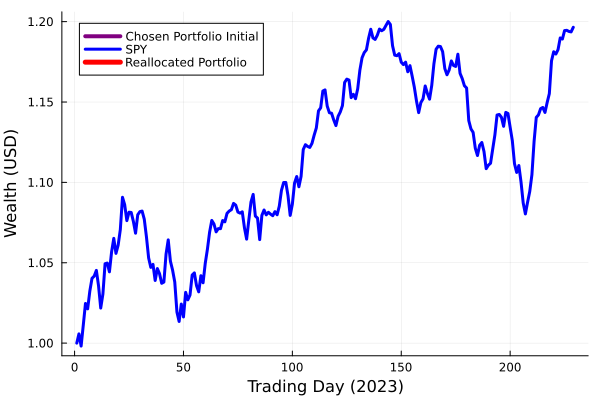

In [177]:
plot((1/table_data[1,end]).*table_data[:,end],
    lw=4, c=:purple, label="Chosen Portfolio Initial")
plot!((1/SPY_df[1,:volume_weighted_average_price]).*SPY_df[1:trading_days,:volume_weighted_average_price],
    lw=3, c=:blue, label="SPY")
plot!((1/reallocated_portfolio[1,end]).*reallocated_portfolio[:,end], 
    lw=6, c=:red, label="Reallocated Portfolio")

xlabel!("Trading Day (2023)", fontsize=18)
ylabel!("Wealth (USD)", fontsize=18)

In [169]:
shares_array=Array{Float64, 2}(undef, trading_days+1, length(w)+1)
shares_array[1,1]=0
for element in eachindex(tickers)
    shares_array[1,element+1]=N_naught[element]
end

for element in 1:222
    n_vector=results[element,:N_updated]
    shares_array[element+1,1]=element
    for j in eachindex(n_vector)
        shares_array[i+1,j+1]=n_vector[j] |> x -> round(x,digits=3)|> abs
    end
end

header_dt=Array{String,1}()
push!(header_dt,"index")
[push!(header_dt, ticker) for ticker in tickers]
pretty_table(shares_array, header=header_dt)

┌──────────────┬──────────────┬──────────────┬──────────────┬──────────────┬──────────────┬──────────────┐
│        index │         NVDA │          MDT │          AMD │           PG │           MO │          PLD │
├──────────────┼──────────────┼──────────────┼──────────────┼──────────────┼──────────────┼──────────────┤
│          0.0 │     0.226488 │          0.0 │      15.1137 │          0.0 │          0.0 │          0.0 │
│          1.0 │ 5.73992e-314 │          0.0 │  3.06057e-23 │ 5.73993e-314 │          0.0 │          0.0 │
│          2.0 │ 8.48798e-314 │ 5.73992e-314 │          0.0 │     4.0e-323 │          0.0 │          0.0 │
│          3.0 │ 5.73992e-314 │ 8.48798e-314 │ 5.73992e-314 │          0.0 │          NaN │          0.0 │
│          4.0 │     4.0e-323 │          0.0 │ 8.48798e-314 │          NaN │ 5.73993e-314 │   2.122e-314 │
│          5.0 │          0.0 │          0.0 │    3.64e-321 │          NaN │ 5.73993e-314 │          0.0 │
│          6.0 │        1.674 │      

## Disclaimer and Risks
__This content is offered solely for training and  informational purposes__. No offer or solicitation to buy or sell securities or derivative products, or any investment or trading advice or strategy,  is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance.  Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on your evaluation of your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.